In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
import os
os.listdir('drive')

['Shareddrives',
 'MyDrive',
 '.shortcut-targets-by-id',
 '.file-revisions-by-id',
 '.Trash-0']

In [38]:
df = pd.read_csv("/content/drive/MyDrive/Fraud.csv")

In [39]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [41]:
df.shape

(6362620, 11)

In [42]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [43]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [44]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [45]:
df['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [46]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

Text(0.5, 1.0, 'Types of transactions ')

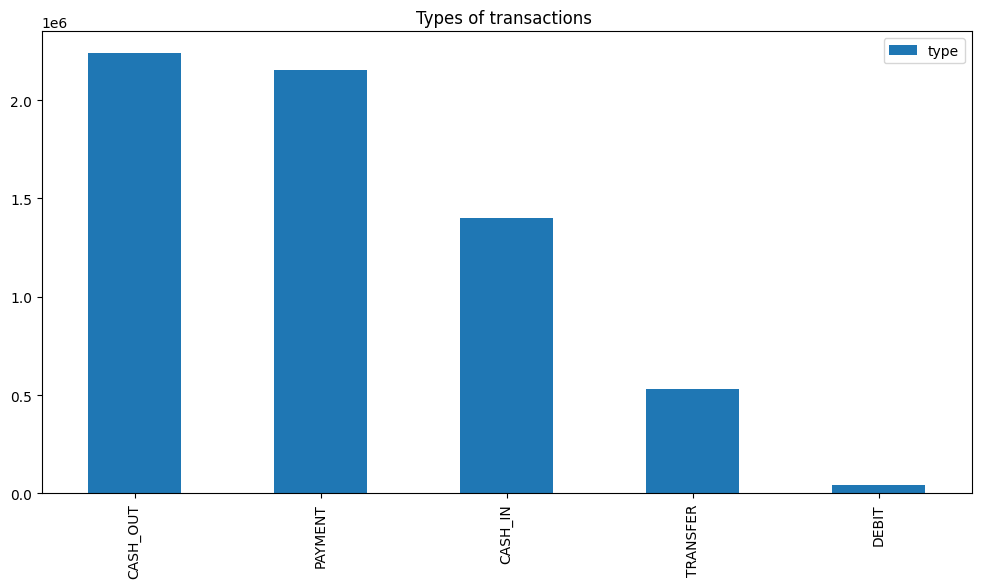

In [47]:
x = df['type'].value_counts()
x.plot(kind='bar', figsize = (12,6))
plt.legend()
plt.title('Types of transactions ')

Text(0.5, 1.0, 'Distribution of transactions flagged fraud and not ')

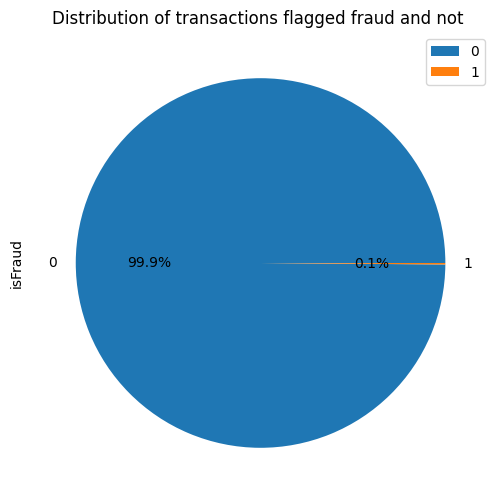

In [48]:
p = df['isFraud'].value_counts()
p.plot(kind='pie', autopct = '%1.1f%%' , figsize = (12,6))
plt.legend()
plt.title('Distribution of transactions flagged fraud and not ')

In [49]:
df.describe

<bound method NDFrame.describe of          step      type      amount     nameOrig  oldbalanceOrg  \
0           1   PAYMENT     9839.64  C1231006815      170136.00   
1           1   PAYMENT     1864.28  C1666544295       21249.00   
2           1  TRANSFER      181.00  C1305486145         181.00   
3           1  CASH_OUT      181.00   C840083671         181.00   
4           1   PAYMENT    11668.14  C2048537720       41554.00   
...       ...       ...         ...          ...            ...   
6362615   743  CASH_OUT   339682.13   C786484425      339682.13   
6362616   743  TRANSFER  6311409.28  C1529008245     6311409.28   
6362617   743  CASH_OUT  6311409.28  C1162922333     6311409.28   
6362618   743  TRANSFER   850002.52  C1685995037      850002.52   
6362619   743  CASH_OUT   850002.52  C1280323807      850002.52   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
0             160296.36  M1979787155            0.00            0.00        0   

In [50]:
df.loc[df.isFraud == 1].type.unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)

In [51]:
import plotly.express as px
pay = df.head(5000)
fig = px.box(pay, y = "amount")
fig.show()

<Axes: >

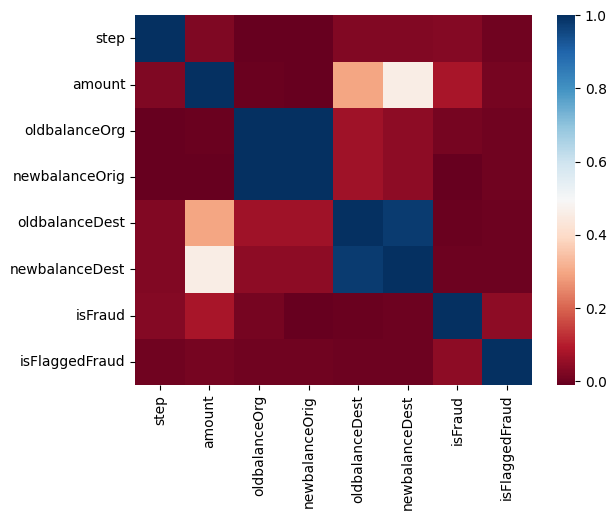

In [52]:
sns.heatmap(df.corr(), cmap='RdBu')

Now , we perform feature engineering , by adding new features as the existing dataset is not enough to do so


In [53]:
df = df.head(50000)

In [54]:
df.shape

(50000, 11)

In [55]:
#Tallying the balance
def balance_diff(data):
    '''balance_diff checks whether the money debited from sender has exactly credited to the receiver
       then it creates a new column which indicates 1 when there is a deviation else 0'''
    #Sender's balance
    orig_change=data['newbalanceOrig']-data['oldbalanceOrg']
    orig_change=orig_change.astype(int)
    for i in orig_change:
        if i<0:
            data['orig_txn_diff']=round(data['amount']+orig_change,2)
        else:
            data['orig_txn_diff']=round(data['amount']-orig_change,2)
    data['orig_txn_diff']=data['orig_txn_diff'].astype(int)
    data['orig_diff'] = [1 if n !=0 else 0 for n in data['orig_txn_diff']]

    #Receiver's balance
    dest_change=data['newbalanceDest']-data['oldbalanceDest']
    dest_change=dest_change.astype(int)
    for i in dest_change:
        if i<0:
            data['dest_txn_diff']=round(data['amount']+dest_change,2)
        else:
            data['dest_txn_diff']=round(data['amount']-dest_change,2)
    data['dest_txn_diff']=data['dest_txn_diff'].astype(int)
    data['dest_diff'] = [1 if n !=0 else 0 for n in data['dest_txn_diff']]

    data.drop(['orig_txn_diff','dest_txn_diff'],axis=1,inplace = True)

#Surge indicator
def surge_indicator(data):
    '''Creates a new column which has 1 if the transaction amount is greater than the threshold
    else it will be 0'''
    data['surge']=[1 if n>450000 else 0 for n in data['amount']]

#Frequency indicator
def frequency_receiver(data):
    '''Creates a new column which has 1 if the receiver receives money from many individuals
    else it will be 0'''
    data['freq_Dest']=data['nameDest'].map(data['nameDest'].value_counts())
    data['freq_dest']=[1 if n>20 else 0 for n in data['freq_Dest']]

    data.drop(['freq_Dest'],axis=1,inplace = True)

#Tracking the receiver as merchant or not
def merchant(data):
    '''We also have customer ids which starts with M in Receiver name, it indicates merchant
    this function will flag if there is a merchant in receiver end '''
    values = ['M']
    conditions = list(map(data['nameDest'].str.contains, values))
    data['merchant'] = np.select(conditions, '1', '0')

In [56]:
balance_diff(df)

df['orig_diff'].value_counts()
df['dest_diff'].value_counts()

1    44994
0     5006
Name: dest_diff, dtype: int64

In [57]:
#Applying surge_indicator function
surge_indicator(df)
df['surge'].value_counts()

0    46392
1     3608
Name: surge, dtype: int64

In [58]:
#Applying frequency_receiver function
frequency_receiver(df)
df['freq_dest'].value_counts()

0    46295
1     3705
Name: freq_dest, dtype: int64

In [59]:
df_1 = df.copy()

In [60]:
max_size = df['isFraud'].value_counts().max()
lst = [df_1]
for class_index, group in df_1.groupby('isFraud'):
  lst.append(group.sample(max_size-len(group), replace = True))
df_1 = pd.concat(lst)

In [61]:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Pie(labels=['Not Fraud','Fraud'], values=df_1['isFraud'].value_counts())])
fig.show()

In [62]:
df_1 = pd.concat([df_1,pd.get_dummies(df_1['type'], prefix='type_')],axis=1)
df_1.drop(['type'],axis=1,inplace = True)
df_1.head()

,step,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,orig_diff,dest_diff,surge,freq_dest,type__CASH_IN,type__CASH_OUT,type__DEBIT,type__PAYMENT,type__TRANSFER
0,1,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0
1,1,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0
2,1,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0,1,0,0,0,0,0,0,1
3,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0,1,0,0,0,1,0,0,0
4,1,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,0,1,0,0,0,0,0,1,0


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
df_2 = df_1.copy()
X = df_2.drop('isFraud',axis=1)
y = df_2['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=111)
col_names=['amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
features_train = X_train[col_names]
features_test = X_test[col_names]
scaler = StandardScaler().fit(features_train.values)
features_train = scaler.transform(features_train.values)
features_test = scaler.transform(features_test.values)
X_train[col_names] = features_train
X_test[col_names] =features_test

In [64]:
X_train=X_train.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_train = X_train.reset_index(drop=True)
X_test=X_test.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1)
X_test = X_test.reset_index(drop=True)

In [65]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
models ={'KNN': KNeighborsClassifier(),
         'LogReg': LogisticRegression(),
         'dtree': DecisionTreeClassifier(),
         'rforest': RandomForestClassifier(),
         'GB': GradientBoostingClassifier()
}
names=[]
scores=[]
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_pred, y_test)
    names.append(name)
    scores.append(score)

In [66]:
results = pd.DataFrame({'model': names, 'score': scores})
results.sort_values(by='score', ascending=False)

,model,score
3,rforest,1.000000
4,GB,0.999967
2,dtree,0.999933
0,KNN,0.998631
1,LogReg,0.974048


So , we can see that Random Forest has the highest classification score and hence , we will use it as well

In [67]:
rforest = RandomForestClassifier()
rforest.fit(X_train, y_train)
y_pred = rforest.predict(X_test)
score = accuracy_score(y_pred, y_test)
print(score)

1.0


So , we have an exact accuracy score of 1 while using Random Forest Classifier

In [68]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14902
           1       1.00      1.00      1.00     15038

    accuracy                           1.00     29940
   macro avg       1.00      1.00      1.00     29940
weighted avg       1.00      1.00      1.00     29940

